In [3]:
#! pip install psycopg2
import psycopg2

In [33]:
conn = psycopg2.connect("dbname=350seattle")

In [34]:
cur = conn.cursor()

In [35]:
# results = cur.execute("SELECT * FROM voters_kc_2017 limit 10");
years = [2017, 2018, 2019]
def table_name(year):
    return f"voters_kc_{year}"

In [36]:
election_dates = {
    2017: '20171107',
    2018: '20181106',
    2019: '20191105'
}
age_ranges = ['Under 35','35-50','Over 50']

In [37]:
def count_voters(year, check_if_voted = False):
    query_str = f"select count(*) from {table_name(year)}"
    if check_if_voted: query_str += " where VOTED = 1"
    create_function = f"""
    create or replace function count_total_registered() returns int as $$
        DECLARE  
            total_registered_voters integer;
        BEGIN  
            return ({query_str});
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select count_total_registered from count_total_registered();")
    return cur.fetchone()[0]

In [38]:
print(count_voters(2017))
print(count_voters(2018))
print(count_voters(2019))

521081
521081
521210


In [39]:
def count_under35_func(year, check_if_voted = False):
    date_str = election_dates[year]
    query_str = f"select count(*) from {table_name(year)} where Birthdate > ((SELECT TO_DATE(\'{date_str}\', 'YYYYMMDD')) - interval '35 years')";
    if check_if_voted: query_str += " and VOTED = 1"
    create_function = f"""
    create or replace function count_under35() returns int as $$
        DECLARE  
            under35 integer;
        BEGIN  
            return ({query_str});
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select * from count_under35()")
    return cur.fetchone()[0]    

In [40]:
print(count_under35_func(2017))
print(count_under35_func(2018))
print(count_under35_func(2019))

226436
214512
202214


In [41]:
def count_over50_func(year, check_if_voted = False):
    date_str = election_dates[year]
    query_str = f"select count(*) from {table_name(year)} where Birthdate < ((SELECT TO_DATE(\'{date_str}\', 'YYYYMMDD')) - interval '50 years')"
    if check_if_voted: query_str += " and VOTED = 1"
    create_function = f"""
    create or replace function count_over50() returns int as $$
        DECLARE  
            over50 integer;
        BEGIN  
            return ({query_str});
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select * from count_over50()")
    return cur.fetchone()[0]    

In [42]:
print(count_over50_func(2017))
print(count_over50_func(2018))
print(count_over50_func(2019))

162260
170079
178262


In [47]:
%matplotlib inline

# https://pstblog.com/2016/10/04/stacked-charts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

# for each year, append 3 of that year to the first item in data
# append the age ranges to the second item in `data`
data_for_bar_chart = [
    [], # years - 2017, 2017, 2017, 2018,
    [], # age_ranges, -- Under 35, 35-50, Over 50, (repeat)
    [], # count registereds,
    []  # Count voted 
]

for year in years:
    data_for_bar_chart[0].extend(np.repeat(year, 3))
    data_for_bar_chart[1].extend(age_ranges)
    # count registereds
    count_over50 = count_over50_func(year)
    count_under35 = count_under35_func(year)
    count_between = count_voters(year) - count_over50 - count_under35 
    data_for_bar_chart[2].extend([count_under35, count_between, count_over50])
    # count voted
    count_over50_voted = count_over50_func(year, check_if_voted=True)
    count_under35_voted = count_under35_func(year, check_if_voted=True)
    count_between_voted = count_voters(year, check_if_voted=True) - count_over50_voted - count_under35_voted 
    data_for_bar_chart[3].extend([count_under35_voted, count_between_voted, count_over50_voted])    

rows = zip(data_for_bar_chart[0], data_for_bar_chart[1], data_for_bar_chart[2], data_for_bar_chart[3])
headers = ['Year', 'Age Ranges', 'Count Registered', 'Count Voted']
df = pd.DataFrame(rows, columns=headers)

df

,Year,Age Ranges,Count Eligible,Count Voted
0,2017,Under 35,226436,40859
1,2017,35-50,132385,54604
2,2017,Over 50,162260,93988
3,2018,Under 35,214512,96775
4,2018,35-50,136490,92509
5,2018,Over 50,170079,129785
6,2019,Under 35,202214,58934
7,2019,35-50,140734,68687
8,2019,Over 50,178262,115270


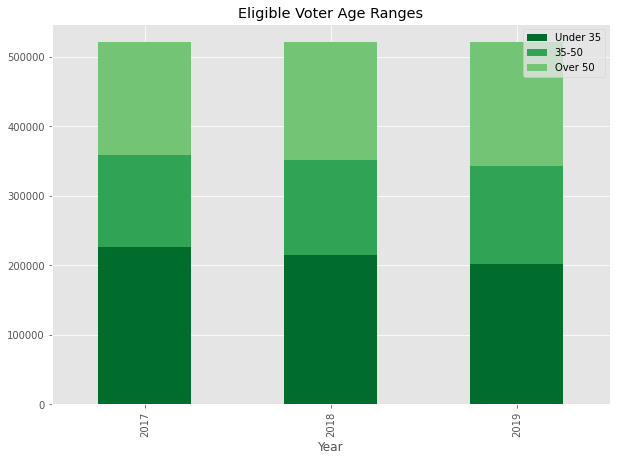

In [59]:
fig, ax = plt.subplots(figsize=(10,7))  

margin_bottom = 2* np.zeros(len(df['Year'].drop_duplicates()))
colors = ["#006D2C", "#31A354","#74C476"]

for num, age_range in enumerate(age_ranges):
    values = list(df[df['Age Ranges'] == age_range].loc[:, 'Count Registered'])
    df[df['Age Ranges'] == age_range].plot.bar(x='Year', y='Count Registered', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=age_range)
    margin_bottom += values   

plt.title('Registered Voter Age Ranges')
plt.show()

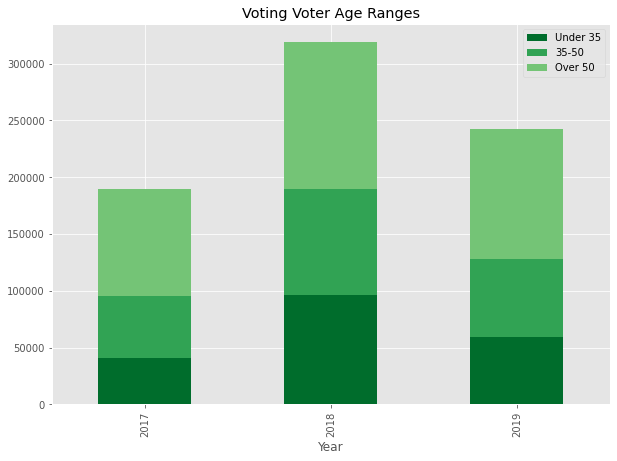

In [60]:
fig, ax = plt.subplots(figsize=(10,7))  

margin_bottom = 2* np.zeros(len(df['Year'].drop_duplicates()))
colors = ["#006D2C", "#31A354","#74C476"]

for num, age_range in enumerate(age_ranges):
    values = list(df[df['Age Ranges'] == age_range].loc[:, 'Count Voted'])
    df[df['Age Ranges'] == age_range].plot.bar(x='Year', y='Count Voted', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=age_range)
    margin_bottom += values    

plt.title('Voting Voter Age Ranges')
plt.show()

# Calculate the “missing youth vote”

Defining the "missing youth vote" as the difference between the number of registered youth voters who actually voted and the number of registered youth voters who would have voted if youth voters voted at the same rate as the over 50 population.

In [74]:
year = 2018
rate_of_over50_voting = count_over50_func(year, check_if_voted=True) / count_over50_func(year)
print(rate_of_over50_voting)
rate_of_under35_voting = count_under35_func(year, check_if_voted=True) / count_under35_func(year)
print(rate_of_under35_voting)

# If youth voted at the same rate as over 50
potential_youth_vote = count_under35_func(year) * rate_of_over50_voting
# Actual youth vote this year
actual_youth_vote = count_under35_func(year, check_if_voted=True)

# Missing vote = 
potential_youth_vote - actual_youth_vote

0.7630865656547839
0.4511402625494145


66916.22537173901